# Gauge transformation of the gauge links in a LC coordinate lattice

## Step 0

### Writting the fields from files

In [1]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = 'su3'

# Import relevant modules
import sys
sys.path.append('..')

import curraun.su as su
import numpy as np
import pickle

Using SU(3)
Using Numba
Using double precision


In [2]:
# I need to add this line to ask resources from a specific GPU, which is free. Our GPU server has no queing system
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
# We read the fields

fields = np.load('gauge_links_fields_glasma_test.npz')
ux = fields['ux']; aeta = fields['aeta']

with open('parameters_gauge_transf_glasma_test.pickle', 'rb') as f:
    param = pickle.load(f)

In [4]:
print(np.shape(ux))
print(np.shape(aeta))

(64, 16384, 9)
(64, 16384, 9)


In [5]:
# We get the relevant parameters

N = param['N']
Dg = param['DG']
L = param['L']
Qs = param['QS']

t_steps = np.shape(ux)[0]

a = L/N
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))

In [6]:
# We reshape the transverse component into a N*N matrix

ux_r = ux.reshape((t_steps, N, N, Dg))
aeta_r = aeta.reshape((t_steps, N, N, Dg))

print(np.shape(ux_r))
print(np.shape(aeta_r))

(64, 128, 128, 9)
(64, 128, 128, 9)


## Step 1

In [7]:
# Supress various horribly long warnings
import warnings
warnings.filterwarnings('ignore')

### We write the relevant magnitude in LC coordinates

In [8]:
# We construct the z links from Aeta

uz = su.GROUP_TYPE([[[[su.mexp(su.mul_s(aeta_r[t,x,y], 1j*g*a*(z-N//2))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])

In [7]:
uz_test = uz.reshape(t_steps, N, N, N, 3, 3)
print(uz_test[t_steps//2, N//2, N//2, 0, :, :])

[[15.23139035-3.13020387e-15j  9.91365669-1.80581101e+00j
   2.70348908-9.12942161e+00j]
 [ 9.91365669+1.80581101e+00j  6.87114893+6.37258503e-16j
   2.59251031-5.48640699e+00j]
 [ 2.70348908+9.12942161e+00j  2.59251031+5.48640699e+00j
   6.66638882+2.17145878e-15j]]


In [8]:
# We define a function that, given a set of gauge links, returns the values over the x^+ axis

def get_LC_links (u_x):
    uminus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],u_x[t,x,y]) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    uplus = su.GROUP_TYPE([[[[su.mul(uz[t,x,y,z],su.GROUP_TYPE(su.dagger(u_x[t,x,y]))) for z in range(N)] for y in range(N)] for x in range(N)] for t in range(t_steps)])
    return uplus, uminus

In [9]:
u_plus_temp, u_minus_temp = get_LC_links(ux_r)

print(np.shape(u_plus_temp))
print(np.shape(u_minus_temp))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 119:
@myjit
def mul(a, b):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 416:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(64, 128, 128, 128, 9)
(64, 128, 128, 128, 9)


In [10]:
print(u_plus_temp[t_steps//2, N//2, N//2, N//2, :])

[ 0.99609203+0.04924128j -0.03978841+0.0410501j   0.03107388+0.0337957j
  0.03606158+0.04559253j  0.99604994+0.00064922j  0.06490415-0.01710036j
 -0.03280965+0.03033767j -0.06591281-0.01647303j  0.99543185-0.05002718j]


## Step 2

### We gauge transform the relevant quantity to LC gauge

In [11]:
# We construct a function that gives the gauge operator at a given point

def gauge_operator(u, x):
    v = su.GROUP_TYPE([[su.unit() for z in range(N)] for y in range(N)])
    for t in range(x//2):
        buffer = v
        v = su.GROUP_TYPE([[su.mul(u[t,x-t,y,z], buffer[y,z]) for z in range(N)] for y in range(N)])
    return v

In [12]:
# We construct an array with the gauge operator over the x^+ axis

v_LC = su.GROUP_TYPE(np.zeros((t_steps, N, N, Dg)))
for x in range (N):
    if x%2 == 0:
        v_LC[x//2,:,:,:] = gauge_operator(u_minus_temp, x)

print(np.shape(v_LC))

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 440:
@myjit
def unit():
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


(64, 128, 128, 9)


In [13]:
# We construct a function that performs the gauge transformation of the plus link

def act_plus_link (u,v):
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(v[t+1, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [14]:
# We transform the plus link

uplus_LC = act_plus_link(u_plus_temp, v_LC)

print(np.shape(uplus_LC))

(63, 128, 128, 9)


In [15]:
# We plot U_+ at one point of the axis to have some intuition about its value

uplus_LC_r = uplus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uplus_LC_r[t_steps//2, N//2, N//2, :])

[[ 0.97204886+0.20191745j -0.01077528+0.1186107j   0.00228295+0.01267032j]
 [-0.00490373+0.11933453j  0.97630274-0.07841198j  0.16226099+0.00954559j]
 [-0.00610297-0.00695198j -0.15732139+0.0418318j   0.97894823-0.12277978j]]


Close to the identity but not exactly

- - -
We write the $U_+$ gauge link to file

In [16]:
np.savez_compressed('uplus_lc_gauge_transf.npz', uplus=uplus_LC)

Output $U_-$ in a format that is appropriate to be read in C++.

In [17]:
np.save('uplus_lc_gauge_transf.npy', uplus_LC)

In [18]:
np.save('uplus_lc_gauge_transf_time_slice.npy', uplus_LC[0,:,:])

In [19]:
uplus_LC[10,17,:]

array([[ 706.4163219  +193.70964699j, 1163.25841786 +184.5304715j ,
        -513.67618837 +233.0378473j , ..., -290.10619631 -269.73354495j,
        -512.82359212 -378.47429261j,  305.01971967  +16.55916983j],
       [ 619.40668728 +166.71154832j, 1023.08621209 +163.71444135j,
        -448.12213673 +204.70808803j, ..., -254.51001217 -234.60183263j,
        -449.73282816 -332.87986893j,  265.91774589  +13.81013781j],
       [ 543.07814899 +143.35841761j,  899.78557965 +145.25980633j,
        -390.8476069  +179.83680732j, ..., -223.26737025 -203.99503126j,
        -394.38735723 -292.7666465j ,  231.7900657   +11.46331201j],
       ...,
       [ 724.171148   -105.24103983j,   28.74775595 -462.73773936j,
         142.19288313-1559.94465039j, ...,  419.45637894+1313.47217337j,
         869.58324371  -89.10620232j, 2945.07676697 -217.75478219j],
       [ 835.49858612 -121.45199784j,   32.05149871 -535.28547063j,
         165.11537364-1795.39399142j, ...,  482.95244329+1508.27185315j,
       

## Step 3

### We transform $U_-$ to LC gauge as a check

In [20]:
# We construct a function with the gauge operator at the next x^- step to the x^+ axis

v_LC_plus1 = su.GROUP_TYPE([[[su.mul(u_minus_temp[t,t,y,z], v_LC[t,y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])

In [21]:
# We construct a function that performs the gauge transformation of the minus links

def act_minus_links(u, v, aux): #TODO: Writte the function with only u and v as inputs?
    buffer1 = su.GROUP_TYPE([[[su.mul(su.GROUP_TYPE(su.dagger(aux[t, y, z])), u[t, t, y,z]) for z in range(N)] for y in range(N)] for t in range(t_steps-1)])
    r = su.GROUP_TYPE([[[su.mul(buffer1[t,y,z], v[t,y,z]) for z in range(N)] for y in range(N)] for t in range (t_steps-1)])
    return r

In [22]:
# We transform the minus link

uminus_LC = act_minus_links(u_minus_temp, v_LC, v_LC_plus1)

print(np.shape(uminus_LC))

(63, 128, 128, 9)


In [23]:
# We plot U_- at one point of the axis to check that it is close to identity

uminus_LC_r = uminus_LC.reshape((t_steps-1, N, N, 3, 3))
print(uminus_LC_r[t_steps//2, N//2, N//2, :, :])

[[ 1.00000000e+00-6.93889390e-17j  9.49934575e-15-1.13312137e-14j
  -3.15719673e-15-2.03021684e-15j]
 [ 9.56613261e-15+1.14006027e-14j  1.00000000e+00+8.32667268e-17j
  -2.88657986e-15+3.18013443e-15j]
 [-3.02535774e-15+1.81972493e-15j -3.05311332e-15-3.19189120e-15j
   1.00000000e+00-5.78094473e-17j]]


The gauge links in minus direction are indeed transformed to the identity. Much closer to 1 that $U_+$ links

# Step 4

### We plot the transformed links

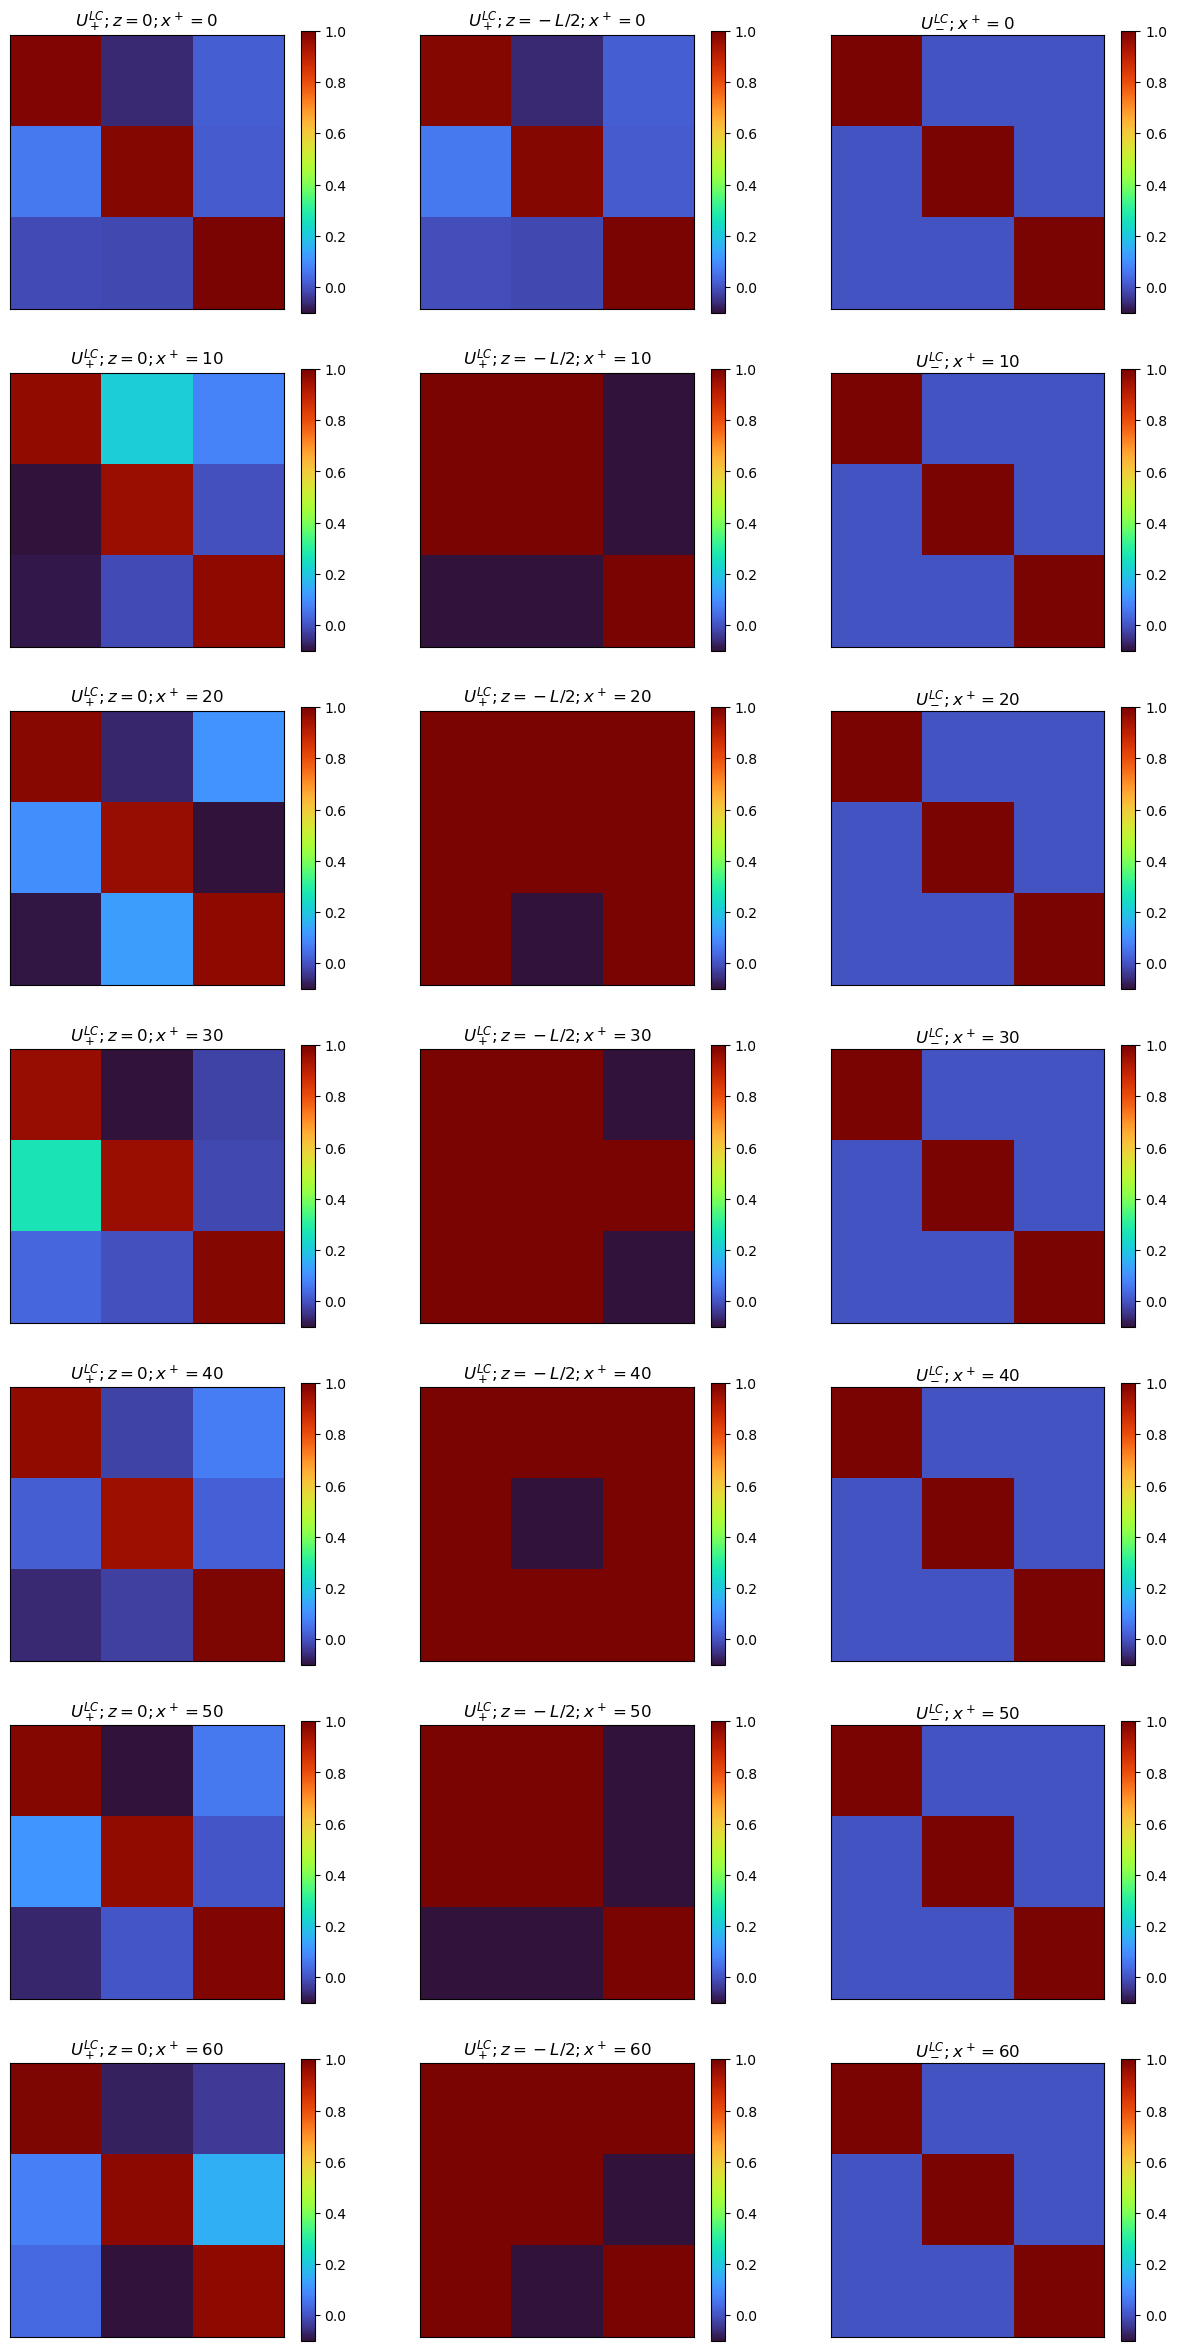

In [24]:
import matplotlib.pyplot as plt 

y = N//2; z = N//2

fig, axs = plt.subplots(t_steps//10 +1, 3, figsize=(15,30))

for t in range(t_steps//10 + 1): 
    tau = 10*t
    
    plot1 = axs[t,0].imshow(uplus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,0].set_title(r'$U_+^{LC}; z=0; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,0])
    axs[t,0].axes.get_xaxis().set_visible(False)
    axs[t,0].axes.get_yaxis().set_visible(False)
    
    plot2 = axs[t,1].imshow(uplus_LC_r[tau, y, 0, :, :].real, cmap='turbo', vmin=-0.1, vmax=1) 
    axs[t,1].set_title(r'$U_+^{LC}; z=-L/2; x^+ = %i $' %tau)
    plt.colorbar(plot1, ax = axs[t,1])
    axs[t,1].axes.get_xaxis().set_visible(False)
    axs[t,1].axes.get_yaxis().set_visible(False)
    
    plot3 = axs[t, 2].imshow(uminus_LC_r[tau, y, z, :, :].real, cmap='turbo', vmin=-0.1, vmax=1)
    axs[t,2].set_title(r'$U_-^{LC}; x^+ = %i $' %tau)
    plt.colorbar(plot3, ax = axs[t,2])
    axs[t,2].axes.get_xaxis().set_visible(False)
    axs[t,2].axes.get_yaxis().set_visible(False)

In [25]:
for t in range (t_steps//10):

    n = su.tr(np.array(su.mul(u_plus_temp[10*t, N//2, :], su.dagger(uplus_LC[10*t, N//2, :]))) - su.unit())
    d = su.sq(u_plus_temp[10*t, N//2, :] - su.unit())

    r = n/d
    print(r)
# plt.imshow(p.real, cmap='turbo', vmin=-0.1, vmax=1) 


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../curraun/su3.py", line 416:
@myjit
def dagger(a):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/lustre/HQCD/carlos.lamas/curraun/curraun/su3.py:460: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "sq" failed type inference due to: No implementation of function Function(<built-in function iadd>) found for signature:
 
 >>> iadd(float64, array(float64, 2d, C))
 
There are 16 candidate implementations:
  - Of which 14 did not match due to:
  Overload of function 'iadd': File: <numerous>: Line N/A.
    With argument(s): '(float64, array(float64, 2d, C))':
   No match.
  - Of which 2 did not match due to:
  Operator Overload in function 'iadd': File: unknown: Line unknown.
    With argument(s): '(float64, array(float64, 2d, C))':
   No match for registered cases:
    * (int64, int64) -> int64
    * (int64, uint64) -> int64
    * (uint64, int64) -> int64
    * (uint64, uint64) -> uint64
    * (float32, float32) -> float32
    * (float64, float64) -> float64
    * (complex64, complex64) -> complex64
    * (complex128, complex128) -> 

[[ 23.92176409-8.66558256j   0.78810399-0.43073418j
   -0.97740051-0.13416603j ...  -0.87258145+0.29526754j
   -0.2119541 +0.3578259j  170.32582031+4.7650879j ]
 [ 23.92158283-8.66553834j   0.78810223-0.43070656j
   -0.97754536-0.1342077j  ...  -0.87252387+0.29528877j
   -0.21196044+0.35778194j 170.33006946+4.76512344j]
 [ 23.92140133-8.66549404j   0.78810047-0.43067893j
   -0.97769022-0.13424939j ...  -0.87246623+0.29530994j
   -0.21196677+0.35773797j 170.33431412+4.76515885j]
 ...
 [ 23.89718382-8.65934193j   0.78780394-0.42724679j
   -0.99553318-0.1395329j  ...  -0.86486729+0.29750459j
   -0.21266595+0.35230617j 170.82179753+4.76851548j]
 [ 23.89697161-8.65928622j   0.78780088-0.42721862j
   -0.99567832-0.13957715j ...  -0.86480163+0.29751925j
   -0.21267099+0.35226184j 170.82547679+4.76853459j]
 [ 23.89675915-8.65923042j   0.78779782-0.42719044j
   -0.99582346-0.13962141j ...  -0.86473591+0.29753385j
   -0.21267603+0.3522175j  170.82915143+4.76855357j]]
[[ 8.67492288e+03-2268.42127

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "sq" was compiled in object mode without forceobj=True.

File "../curraun/su3.py", line 481:
def sq(a): # TODO: rename to tr_sq? or tr_abs_sq?
    <source elided>
    s = GROUP_TYPE_REAL(0)
    for i in range(9):
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../curraun/su3.py", line 481:
def sq(a): # TODO: rename to tr_sq? or tr_abs_sq?
    <source elided>
    s = GROUP_TYPE_REAL(0)
    for i in range(9):
    ^

  warnings.warn(errors.NumbaDepreca